In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import sys
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 


# Root directory of the project
ROOT_DIR = os.path.abspath("../")
INPUT_DIR = os.path.join(ROOT_DIR, 'considition-challenge')
DATASET_DIR = os.path.join(ROOT_DIR, 'Training_dataset')
DATA_DIR = os.path.join(os.getcwd(), 'data')
MODEL_DIR = os.path.join(os.getcwd(), 'logs')
SRC_DIR = os.path.join(os.getcwd(), 'src')

In [3]:
from utils import *

import_file(ROOT_DIR, confirm = None)

recreate_data(ROOT_DIR, INPUT_DIR, confirm = None)

source_dir, destination_dir, images_dir, masks_dir, percentages_dir, \
        annotations_dir, train_dir, train_images_dir, train_masks_dir, \
        train_percentages_dir, train_annotations_dir, validation_dir, \
        validation_images_dir, validation_masks_dir, validation_percentages_dir, \
        validation_annotations_dir, all_dir, all_images_dir, all_masks_dir, \
        all_percentages_dir, all_annotations_dir = define_dir(ROOT_DIR)

No changes were made at considition-challenge directories


Using TensorFlow backend.


In [4]:
percentages, df_results, list_exclude_files, id_to_name_list = summarize_percentages(percentages_dir, annotations_dir)

def fn_1(x):
    if x in list_exclude_files:
        return 1
    else:
        return 0
    
df_results['x'] = df_results['imageName'].apply(lambda x: fn_1(x))


df_results['hasBuilding'] = df_results['buildingPercentage'].apply(lambda x: 1 if x > 0 else 0)
df_results['hasRoad'] = df_results['roadPercentage'].apply(lambda x: 1 if x > 0 else 0)
df_results['hasWater'] = df_results['waterPercentage'].apply(lambda x: 1 if x > 0 else 0)

df_results['labels'] = df_results['baseName'].astype(str) + df_results['hasBuilding'].astype(str) + df_results['hasRoad'].astype(str) + df_results['hasWater'].astype(str)
df_results.loc[df_results['labels']=='moz2101',['labels']] = 'moz2001'


df_results_clean = df_results.loc[df_results['x']==0,]
del df_results_clean['x']

df_x_ = df_results_clean.loc[:,['imageName']]
df_y_ = df_results_clean.loc[:,'labels']

df_complete = df_results.copy()
df_y = df_y_.copy()
df_x = df_x_.copy()


df_x['image'] = df_x['imageName'].transform(lambda x: x.split('.')[0])
df_complete['image'] = df_complete['imageName'].transform(lambda x: x.split('.')[0])

train_list_jpg, val_list_jpg, all_list_jpg, train_list, val_list, all_list = create_train_test_split(df_complete, X = df_x, y = df_y, split = 0.15, seed = 4242)

def copy_from_to_dir(source_dir, destination_dir, ext, filename):
    this_file = source_dir + filename + ext
    destination = destination_dir + filename + ext
    copyfile(this_file, destination)


def split_data(source_dir, train_list, val_list, all_list):       

    training_set = train_list 
    validation_set = val_list
    all_set = all_list

    for filename in training_set:
        copy_from_to_dir(images_dir, train_images_dir, '.jpg', filename)
        copy_from_to_dir(masks_dir, train_masks_dir, '.png', filename)
        copy_from_to_dir(percentages_dir, train_percentages_dir, '.json', filename)

    for filename in validation_set:
        copy_from_to_dir(images_dir, validation_images_dir, '.jpg', filename)
        copy_from_to_dir(masks_dir, validation_masks_dir, '.png', filename)
        copy_from_to_dir(percentages_dir, validation_percentages_dir, '.json', filename)
        
    for filename in all_set:
        copy_from_to_dir(images_dir, all_images_dir, '.jpg', filename)
        copy_from_to_dir(masks_dir, all_masks_dir, '.png', filename)
        copy_from_to_dir(percentages_dir, all_percentages_dir, '.json', filename)
        
def split_json(image_names, annotations_dir, dest_annotations_dir, subset):
    
    # Load json from file
    json_file = open(os.path.join(annotations_dir,'master_train.json'))
    coco_json = json.load(json_file)
    json_file.close()

    # Get all images and add them to the dataset
    images_id_list = []
    seen_images = {}
    for image in coco_json['images']:
        image_id = image['id']
        image_file_name = image['file_name']
        if image_file_name in image_names:
            if image_id not in seen_images:
                seen_images[image_id] = image
            images_id_list.append(image_id)
    
    new_img_json=[item for item in coco_json['images'] if item['id']  in images_id_list]
    new_ann_json=[item for item in coco_json['annotations'] if (item['image_id']  in images_id_list) and (item['area']>0)]
    
    new_json = {'images': '',
                'annotations': '',
                'info': '',
                'categories': '',
                'licenses': '' }
    
    new_json['info'] = coco_json['info']
    new_json['categories'] = coco_json['categories']
    new_json['licenses'] = coco_json['licenses']
    new_json['images'] = new_img_json
    new_json['annotations'] = new_ann_json                   
                     
    with open('{}.json' .format(subset), 'w') as outfile:
        json.dump(new_json, outfile)
    
    if subset == 'train':
        copy_from_to_dir(os.getcwd(), dest_annotations_dir, '.json', '/train')
    if subset == 'validation':
        copy_from_to_dir(os.getcwd(), dest_annotations_dir, '.json', '/validation')
    if subset == 'all':
        copy_from_to_dir(os.getcwd(), dest_annotations_dir, '.json', '/all')
        
def move_files(confirm = None):
    
    if confirm is not None:
        split_data(images_dir, train_list, val_list, all_list)
        split_json(train_list_jpg, annotations_dir, train_annotations_dir, 'train')
        split_json(val_list_jpg, annotations_dir, validation_annotations_dir, 'validation')
        split_json(all_list_jpg, annotations_dir, all_annotations_dir, 'all')
        return print('Files have been copied and json files edited')
    else:
        return print('No changes were made')



move_files(confirm = None)

There are 1394 training images
There are 246 validation images
There are 1670 images 

Train : 41 different types
Valid : 37 different types
No changes were made


data_frame = pd.read_csv('data/0k_mosaic.csv')

from augment_preprocess import make_n_save_mosaic
make_n_save_mosaic('0k_mosaic.csv', INPUT_DIR, all_dir)

In [5]:
from train import consid_dataset
train_set = consid_dataset()
train_set.load_data(INPUT_DIR, 'train', add_subset = 'Mosaics')
train_set.prepare()
print('Train dataset: {}' .format(len(train_set.image_ids)))

# test/val set
val_set = consid_dataset()
val_set.load_data(INPUT_DIR, 'validation')
val_set.prepare()
print('Test dataset: {}' .format(len(val_set.image_ids)))

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
Train dataset: 1540
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Test dataset: 246


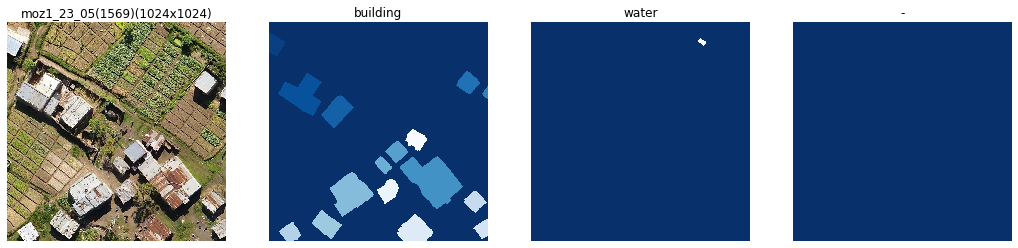

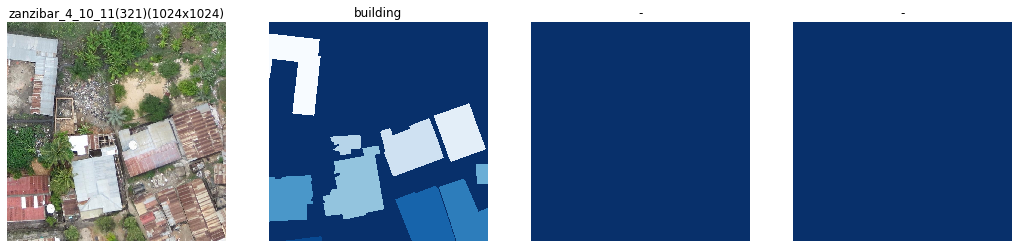

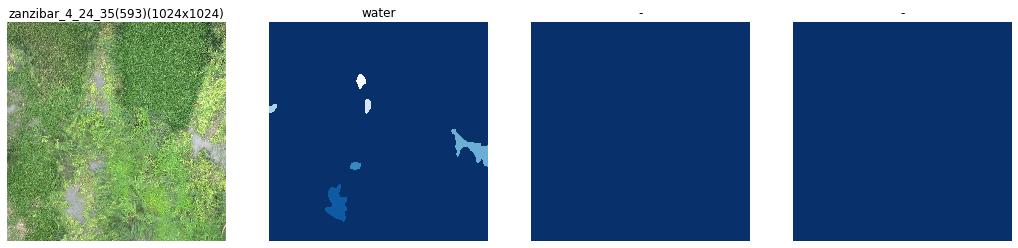

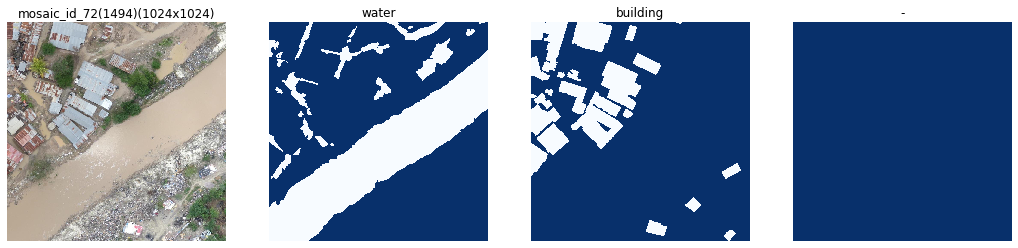

In [6]:
# Load and display random samples
from utils import display_top_masks

dataset = train_set
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    img_id, img_name = dataset.image_info[image_id]['id'], dataset.image_info[image_id]['img_name']
    display_top_masks(image, mask, class_ids, dataset.class_names, img_id, img_name)

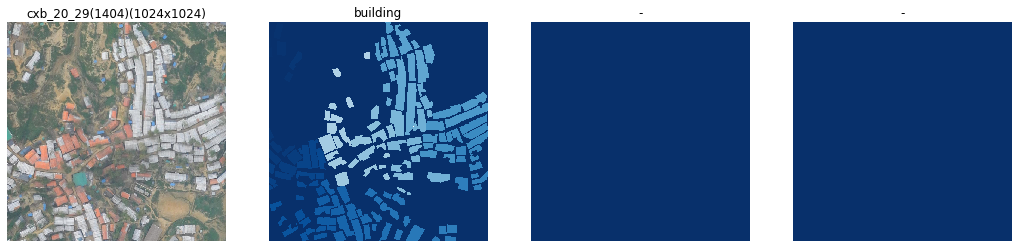

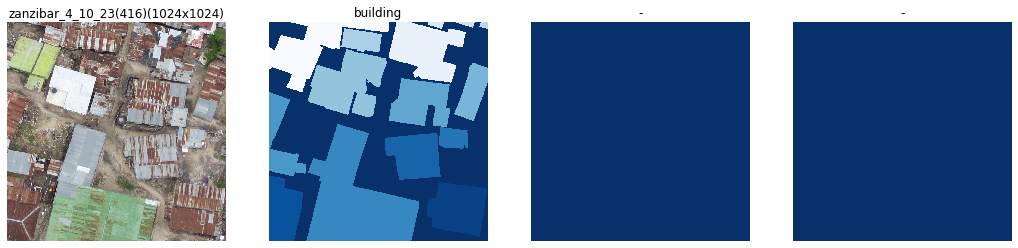

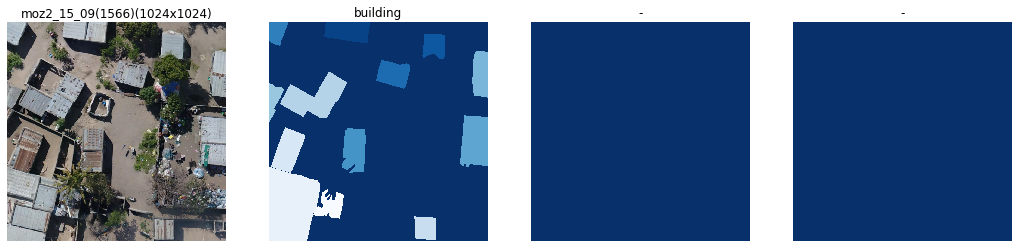

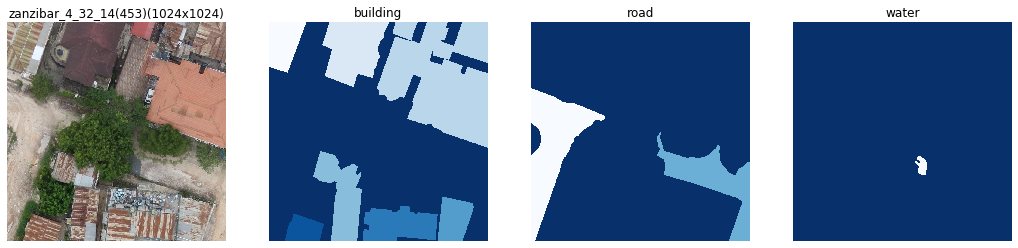

In [7]:
dataset = val_set
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    img_id, img_name = dataset.image_info[image_id]['id'], dataset.image_info[image_id]['img_name']
    display_top_masks(image, mask, class_ids, dataset.class_names, img_id, img_name)

### Configuration file

Define configurations for training our dataset.

In [20]:
from config import GlobheConfig
config = GlobheConfig()
config.display()


Configurations:
AUGMENT                        False
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
CROP                           False
CROP_SHAPE                     [256 256   3]
DETECTION_MASK_THRESHOLD       0.7
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_COLOR                    RGB
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  300
IMAGE_MIN_SCALE                0
IMAGE_NORMALIZE                False
IMAGE_PADDING                  True
IMAGE_RESIZ

### Create the model for training

In [21]:
from model import create_load_model

model = create_load_model(config, mode = 'training', log_dir = MODEL_DIR, init_with = 'imagenet', model_path = None)

Initializing model using imagenet in training mode.
Loading weights from  /home/daragaki/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [22]:
from augment_preprocess import augmentation_pipeline
augmentation = augmentation_pipeline()

## Training process

### Step 1
Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.
Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(train_set, val_set, 
            learning_rate = config.LEARNING_RATE/10, 
            epochs = 10, 
            layers = 'heads',
            augmentation = augmentation)

history = model.keras_model.history.history

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/daragaki/considition/logs/globhe20191022T0631/mask_rcnn_globhe_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcn

### Step 2

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(train_set, val_set, 
            learning_rate=config.LEARNING_RATE/10,
            epochs=20, 
            layers="4+",
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(train_set, val_set, 
            learning_rate=config.LEARNING_RATE/100, 
            epochs=30, 
            layers="all",
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [ ]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

In [ ]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [ ]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

## Validation

Define setting to run Inference

In [ ]:
class InferenceConfig(GlobheConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024
    DETECTION_MIN_CONFIDENCE = 0.8
    

inference_config = InferenceConfig()

In [ ]:
from model import create_load_model


model = create_load_model(inference_config, mode = 'inference', log_dir = MODEL_DIR, init_with = None, model_path = '/home/daragaki/considition/logs/globhe20191022T0232/mask_rcnn_globhe_0009.h5')

In [ ]:
import skimage
real_test_dir = os.path.join(INPUT_DIR, 'validation/Images')
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                val_set.class_names, r['scores'], figsize=(5,5))

Run object detection ---from DEMO

In [ ]:
import random

IMAGE_DIR = os.path.join(INPUT_DIR, 'validation/Images')
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            val_set.class_names, r['scores'])

# Run Detection

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Precision-recall

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
plot_precision_recall(AP, precisions, recalls)

In [ ]:
# Grid of ground truth objects and their predictions
plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

#### Compute mAP @ IoU=50 on Batch of Images


In [ ]:
# Compute VOC-style Average Precision
#from utils import compute_batch_ap
import model as modellib
def compute_batch_ap(image_ids, dataset, config, model):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs




# Pick a set of random images
image_ids = np.random.choice(val_set.image_ids, 10)
APs = compute_batch_ap(image_ids, val_set, inference_config, model)
print("mAP @ IoU=50: ", np.mean(APs))

pneumonia

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = val_set
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config, 
                               image_id, use_mini_mask=False)
    #print(gt_class_id)    
    plt.subplot(6, 2, 2*i + 1)
    display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                ax=fig.axes[-1]) #colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                ax=fig.axes[-1]) #colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])